In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Cross Validation

## TimeGapSplit

We allow for a timeseries split that contains a gap.

You won't always need it, but sometimes you consider these two situations;

- If you have multiple samples per timestamp: you want to make sure that a timestamp doesn’t appear at the same time in training and validation folds.
- If your target is looking $x$ days ahead in the future. In this case you cannot construct the target of the last x days of your available data. It means that when you put your model in production, the first day that you are going to score is always x days after your last training sample, therefore you should select the best model according to that setup. In other words, if you keep that gap in the validation, your metric might be overestimated because those first x days might be easier to predict since they are closer to the training set. If you want to be strict in terms of robustness you might want to replicate in the CV exactly this real-world behaviour, and thus you want to introduce a gap of x days between your training and validation folds.

TimeGapSplit provides 3 parameters to really reproduce your production implementation in your cross-validation schema. We will demonstrate this in a code example below. 

#### Examples

Let's make some random data to start with, and next define a plotting function.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklego.model_selection import TimeGapSplit

In [3]:
df = (pd.DataFrame(np.random.randint(0, 30, size=(30, 4)), columns=list('ABCy'))
      .assign(date=pd.date_range(start='1/1/2018', end='1/30/2018')[::-1]))
print(df.shape)

# For performance testing
if False:
    df = pd.concat([df]*50000, axis=0)
    df = df.reset_index(drop=True)
    df.index = df.index + 22
    print(df.shape)

(30, 5)


In [4]:
df.head()

,A,B,C,y,date
0,6,26,6,8,2018-01-30
1,8,26,24,2,2018-01-29
2,5,22,13,9,2018-01-28
3,21,29,14,24,2018-01-27
4,15,25,19,7,2018-01-26


In [5]:
def plot_cv(cv, X):
    """
    Plot all the folds on time axis
    :param pandas.DataFrame X:
    """
    X_index_df = cv.join_date_and_x(X)

    plt.figure(figsize=(16, 4))
    for i, split in enumerate(cv.split(X)):
        x_idx, y_idx = split
        x_dates = X_index_df.iloc[x_idx]['__date__'].unique()
        y_dates = X_index_df.iloc[y_idx]['__date__'].unique()
        plt.plot(x_dates, i*np.ones(x_dates.shape), c="steelblue")
        plt.plot(y_dates, i*np.ones(y_dates.shape), c="orange")

    plt.legend(('training', 'validation'), loc='upper left')
    plt.ylabel('Fold id')
    plt.axvline(x=X_index_df['__date__'].min(), color='gray', label='x')
    plt.axvline(x=X_index_df['__date__'].max(), color='gray', label='d')

**Example 1**

In [6]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=2),
                  gap_duration=timedelta(days=1))

/Users/scollot/accelerator/TimeSerieSplit/scikit-lego-new/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


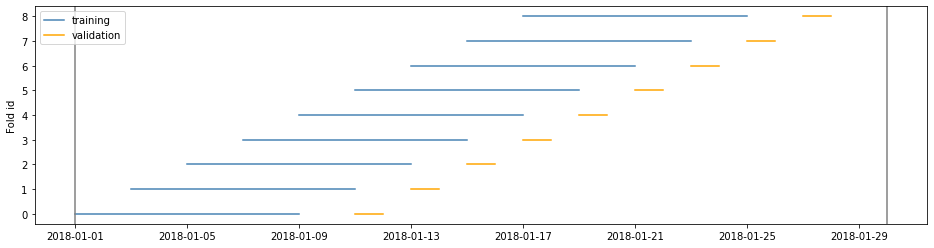

In [7]:
plot_cv(cv, df)

**Example 2**

In [8]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=5),
                  gap_duration=timedelta(days=1))

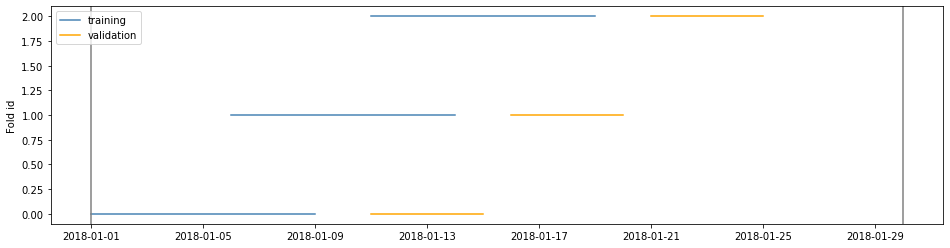

In [9]:
plot_cv(cv, df)

In [10]:
cv.summary(df)

,Start date,End date,Period,Unique days,nbr samples
"(0, train)",2018-01-01,2018-01-09,8 days,9,9
"(0, valid)",2018-01-11,2018-01-15,4 days,5,5
"(1, train)",2018-01-06,2018-01-14,8 days,9,9
"(1, valid)",2018-01-16,2018-01-20,4 days,5,5
"(2, train)",2018-01-11,2018-01-19,8 days,9,9
"(2, valid)",2018-01-21,2018-01-25,4 days,5,5
